# Load libraries and initalize functions

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

from scipy.stats import wilcoxon, friedmanchisquare, kruskal, mannwhitneyu
from statsmodels.stats.inter_rater import aggregate_raters

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

%matplotlib inline

In [33]:
def track_to_long(data, track, columns_general, columns_track, numparts):
    data_track = data[data['track']==track].copy(deep=True)
    data_track.dropna(axis=1, how='all', inplace=True)
    data_track_long = pd.DataFrame(columns=columns_general + columns_track)
    for part_index in range(1, numparts+1):
        columns_track_extracted = [col for col in data_track.columns if f'part_{part_index}' in col]
        data_track_part = data_track[columns_track_extracted].copy(deep=True)
        data_track_part.columns = [col.rsplit(f'part_{part_index}_')[-1] for col in data_track_part.columns]
        data_track_part = data_track_part[columns_track]
        data_track_general = data_track[columns_general].copy(deep=True)
        data_track_long = pd.concat([data_track_long, pd.concat([data_track_general, data_track_part], axis=1)], axis=0)
    return data_track_long

def calc_alpha(pivot_df):
    ratings = aggregate_raters(pivot_df)
    rat_votes = ratings[0][:,:-1]
    rat_cats = ratings[1][:-1]
    ratings = (rat_votes, rat_cats)
    return pg.cronbach_alpha(data=pd.DataFrame(ratings[0]).transpose())

def pval_to_string(pval):
    if pval<0.001:
        return '<0.001'
    else:
        return f'={pval:.3f}'
    
def _pooled_std(x, y):
    """
    Calculate the pooled standard deviation of x and y. Reused from autorank package.
    """
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)


def cohen_d(x, y):
    """
    Calculate the effect size using Cohen's d. Reused from autorank package.
    """
    return (np.mean(x) - np.mean(y)) / _pooled_std(x, y)

def cohen_d_onesample(x, mu):
    """
    Calculate the effect size using Cohen's d for a one-sample test.
    """
    return (np.mean(x) - mu) / np.std(x, ddof=1)


# Prepare data paths and global variables

In [34]:
survey_data_path = 'data/survey_data.csv'
linguistic_data_path = 'data/answers-with-linguistic-markers.csv'
free_text_annotations_path = 'data/exit_poll_free_text_annotated.csv'
free_text_codebook_path = 'data/exit_poll_code_categories.csv'

fwor = 0.05
number_of_comparisons = 17
sig_level = fwor / number_of_comparisons

# Data Preparation

In [35]:
data = pd.read_csv(survey_data_path)

columns_general = ['prolific_id', 'age', 'gender', 'political_preference', 'politically_interested', 'uk_country_of_residence']
columns_track1 = ['pair_id', 'speaker', 'authenticity', 'relevancy', 'coherency', 'duration_in_secs', 'finished', 'speaker_description', 'question', 'answer', 'is_answer_generated']
track1_numparts = 8
columns_track2 = ['pair_id', 'speaker',  'authenticity', 'relevancy', 'coherency', 'content', 'is_left_generated', 'question', 'left_answer', 'right_answer', 'speaker_description']
track2_numparts = 4
columns_track3 = ['pair_id', 'speaker', 'confidence', 'credibility', 'familarity', 'is_answer_generated', 'is_speaker_random', 'question', 'answer', 'speaker_description']
track3_numparts = 8

columns_exit_poll = ['prolific_id', 'exit1_chatbot_knowledge', 'exit1_chatbot_participant_debate', 'exit1_chatbot_participant_debate_details', 'exit1_chatbot_participant_debate_label',
                     'exit1_chatbot_participant_debate_regulated', 'exit1_chatbot_usefull_debate', 'exit2_chatbot_knowledge', 'exit2_chatbot_participant_debate',
                     'exit2_chatbot_participant_debate_details', 'exit2_chatbot_participant_debate_label', 'exit2_chatbot_participant_debate_regulated', 'exit2_chatbot_usefull_debate',
                     'exit2_reason_changes']

data_demographics = data[columns_general].copy(deep=True)
data_track1_long = track_to_long(data, 1, columns_general, columns_track1, track1_numparts)
data_track2_long = track_to_long(data, 2, columns_general, columns_track2, track2_numparts)
data_track3_long = track_to_long(data, 3, columns_general, columns_track3, track3_numparts)
exit_poll = data[columns_exit_poll]

gender_map = {'male': 'Male',
              'female': 'Female',
              'other': 'Other',
              'not_disclosed':
              'Prefer not to disclose'}

residence_map = {'england':
                 'England',
                 'scotland': 'Scotland',
                 'wales': 'Wales',
                 'northern_ireland':
                 'Northern Ireland'}

politically_interested_map = {'yes': 'Yes',
                              'no': 'No',
                              'not_disclosed':
                              'Prefer not to disclose'}

politically_preference_map = {'tories': 'Conservative and Unionist Party',
                              'labor': 'Labour Party',
                              'snp': 'Scottish National Party',
                              'liberal_democrats': 'Liberal Democrats',
                              'dup': 'Democratic Unionist Party',
                              'sinn_fein': 'Sinn Féin',
                              'plaid_cymru': 'Plaid Cymru',
                              'sdlp': 'Social Democratic and Labour Party',
                              'alba_party': 'Alba Party',
                              'greens': 'Green Party of England and Wales',
                              'apni': 'Alliance Party of Northern Ireland',
                              'uup': 'Ulster Unionist Party',
                              'scottish_greens': 'Scottish Greens',
                              'tuv': 'Traditional Unionist Voice',
                              'pbp': 'People Before Profit',
                              'no_preference': 'No preference',
                              'not_disclosed': 'Prefer not to disclose'}

likert_scale_map_agreement = {'Strongly disagree':-2,
                              'Disagree': -1,
                              'Neutral': 0,
                              'Agree': 1,
                              'Strongly agree': 2}

likert_scale_map_confidence = {'I am unsure whether my judgment is correct': -2,
                               'I have some doubts regarding my judgment': -1,
                               'I am somewhat certain that my judgment is correct': 0,
                               'I am fairly certain that my judgment is correct': 1,
                               'I am certain that my judgment is correct': 2}

likert_scale_map_familarity = {'I am not familiar with the speaker': -2,
                               'My familiarity with the speaker is limited': -1,
                               'I am fairly familiar with the speaker': 0,
                               'I am somewhat familiar with the speaker': 1,
                               'I am familiar with the speaker': 2}

likert_scale_map_authenticity = {'Left significantly more authentic': -2,
                                 'Left more authentic': -1,
                                 'Both equally authentic': 0,
                                 'Right more authentic': 1,
                                 'Right significantly more authentic': 2}

likert_scale_map_relevancy = {'Left significantly more relevant': -2,
                                'Left more relevant': -1,
                                'Both equally relevant': 0,
                                'Right more relevant': 1,
                                'Right significantly more relevant': 2}

likert_scale_coherent = {'Left significantly more coherent': -2,
                         'Left more coherent': -1,
                         'Both equally coherent': 0,
                         'Right more coherent': 1,
                         'Right significantly more coherent': 2}

data_demographics['gender'] = data_demographics['gender'].map(gender_map)
data_demographics['uk_country_of_residence'] = data_demographics['uk_country_of_residence'].map(residence_map)
data_demographics['politically_interested'] = data_demographics['politically_interested'].map(politically_interested_map)
data_demographics['political_preference'] = data_demographics['political_preference'].map(politically_preference_map)

data_track1_long['authenticity'] = data_track1_long['authenticity'].map(likert_scale_map_agreement)
data_track1_long['relevancy'] = data_track1_long['relevancy'].map(likert_scale_map_agreement)
data_track1_long['coherency'] = data_track1_long['coherency'].map(likert_scale_map_agreement)

data_track2_long['authenticity'] = data_track2_long['authenticity'].map(likert_scale_map_authenticity)
data_track2_long['relevancy'] = data_track2_long['relevancy'].map(likert_scale_map_relevancy)
data_track2_long['coherency'] = data_track2_long['coherency'].map(likert_scale_coherent)
data_track2_long['content'] = data_track2_long['content'].map(likert_scale_map_agreement)

# normalize data so that left is always real and right is always generated
data_track2_long.loc[data_track2_long['is_left_generated']==True, 'authenticity'] = data_track2_long[data_track2_long['is_left_generated']==True]['authenticity'] * -1
data_track2_long.loc[data_track2_long['is_left_generated']==True,'relevancy'] = data_track2_long[data_track2_long['is_left_generated']==True]['relevancy'] * -1
data_track2_long.loc[data_track2_long['is_left_generated']==True,'coherency'] = data_track2_long[data_track2_long['is_left_generated']==True]['coherency'] * -1
data_track2_long.drop(columns=['is_left_generated'], inplace=True)

data_track3_long['confidence'] = data_track3_long['confidence'].map(likert_scale_map_confidence)
data_track3_long['credibility'] = data_track3_long['credibility'].map(likert_scale_map_agreement)
data_track3_long['familarity'] = data_track3_long['familarity'].map(likert_scale_map_familarity)


# Demographics

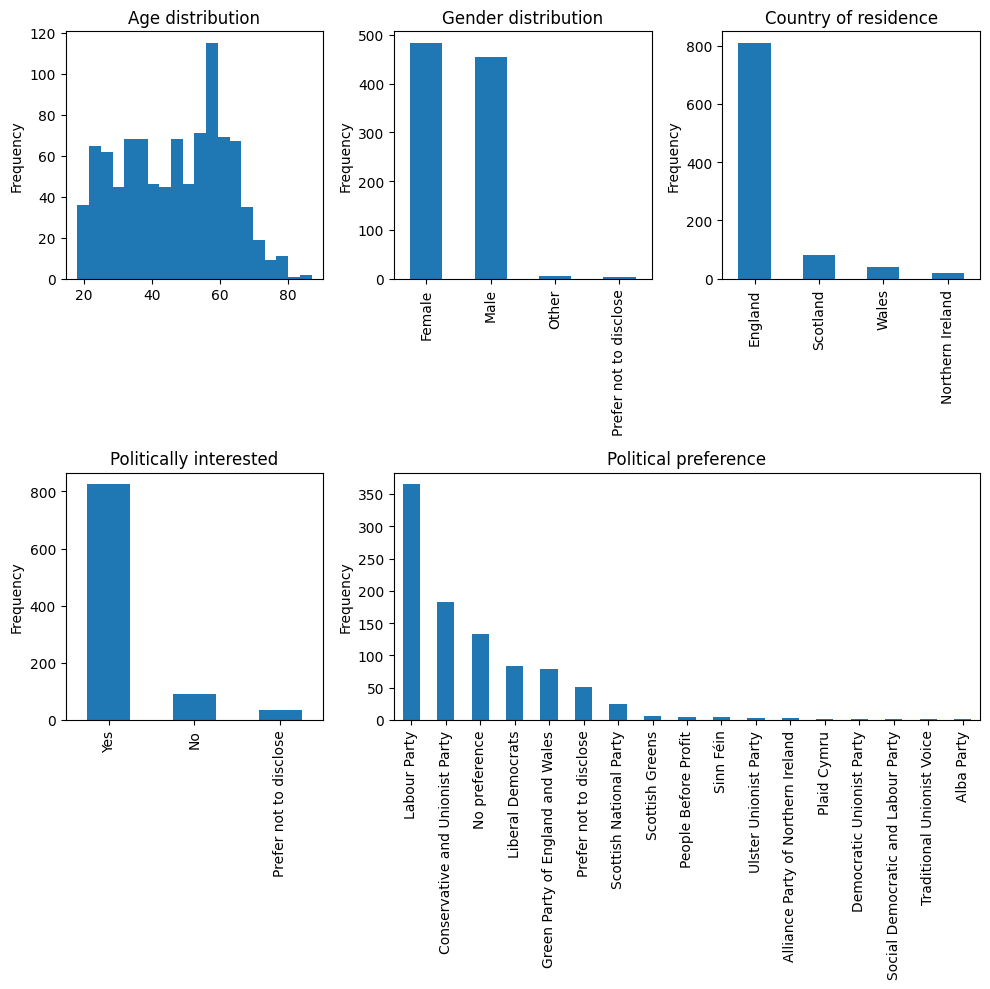

In [36]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid(shape=(2,3), loc=(0,0), colspan=1)
ax2 = plt.subplot2grid(shape=(2,3), loc=(0,1), colspan=1)
ax3 = plt.subplot2grid(shape=(2,3), loc=(0,2), colspan=1)
ax4 = plt.subplot2grid(shape=(2,3), loc=(1,0), colspan=1)
ax5 = plt.subplot2grid(shape=(2,3), loc=(1,1), colspan=2)

data_demographics['age'].plot(kind='hist',bins=20, ax=ax1)
ax1.set_title('Age distribution')
ax1.set_xlabel('')
ax1.set_ylabel('Frequency')
data_demographics['gender'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_title('Gender distribution')
ax2.set_xlabel('')
ax2.set_ylabel('Frequency')
data_demographics['uk_country_of_residence'].value_counts().plot(kind='bar', ax=ax3)
ax3.set_title('Country of residence')
ax3.set_xlabel('')
ax3.set_ylabel('Frequency')
data_demographics['politically_interested'].value_counts().plot(kind='bar', ax=ax4)
ax4.set_title('Politically interested')
ax4.set_xlabel('')
ax4.set_ylabel('Frequency')
data_demographics['political_preference'].value_counts().plot(kind='bar', ax=ax5)
ax5.set_title('Political preference')
ax5.set_xlabel('')
ax5.set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('figures/demographics.pdf', bbox_inches='tight')
plt.show()

# Statistics for Track 1

Stats for Track 1
Number of ratings: 2080
Number data points:  1040



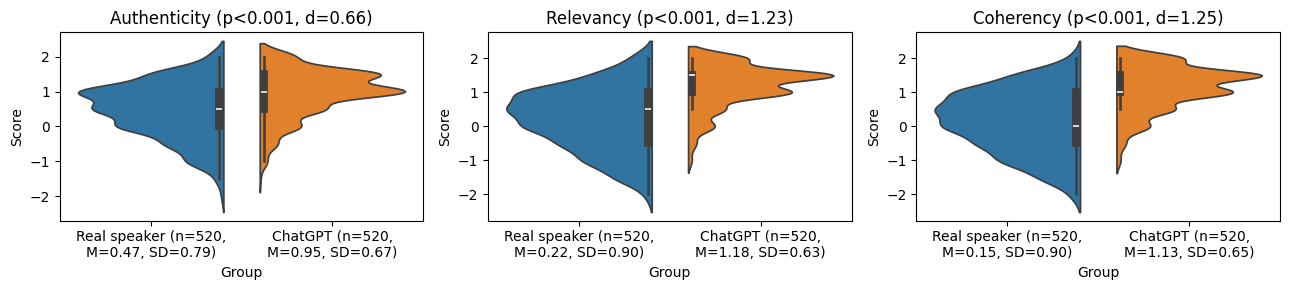

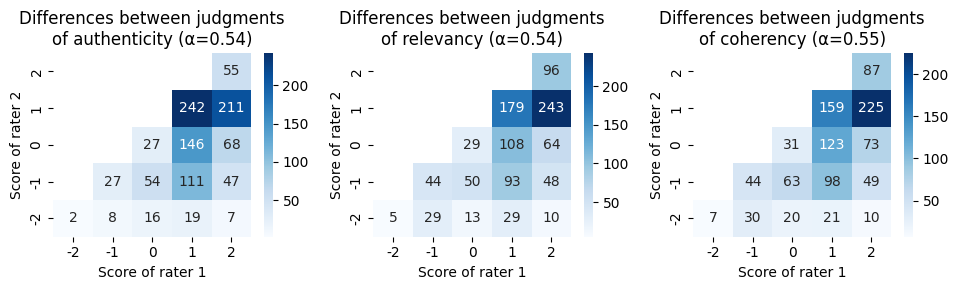

In [37]:
track1_criteria = ['authenticity', 'relevancy', 'coherency']
track1_criteria_labels = ['Authenticity', 'Relevancy', 'Coherency']
track1_meanscores = data_track1_long.groupby(['pair_id', 'is_answer_generated']).mean(numeric_only=True).reset_index()

print('Stats for Track 1')
print('Number of ratings:', len(data_track1_long))
print('Number data points: ', len(track1_meanscores))
print()

# results track 1 (violin plots)
fig, ax = plt.subplots(1, len(track1_criteria), figsize=(13, 3))
for i, criterion in enumerate(track1_criteria):
    # stats
    real_scores = track1_meanscores[track1_meanscores['is_answer_generated']==False][criterion]
    generated_scores = track1_meanscores[track1_meanscores['is_answer_generated']==True][criterion]

    res = wilcoxon(real_scores, generated_scores, alternative='two-sided')
    effsize = cohen_d(generated_scores, real_scores)

    mean_real = real_scores.mean()
    mean_generated = generated_scores.mean()
    sd_real = real_scores.std()
    sd_generated = generated_scores.std()

    label_real = f'Real speaker (n={len(real_scores)},\nM={mean_real:.2f}, SD={sd_real:.2f})'
    label_generated = f'ChatGPT (n={len(generated_scores)},\nM={mean_generated:.2f}, SD={sd_generated:.2f})'

    paired_means = pd.concat([real_scores.reset_index(drop=True), generated_scores.reset_index(drop=True)], axis=1)
    paired_means.columns = [label_real, label_generated]
    sns.violinplot(data=paired_means, ax=ax[i], split=True)
    pval_string = pval_to_string(res.pvalue)
    ax[i].set_title(f'{track1_criteria_labels[i]} (p{pval_string}, d={effsize:.2f})')
    ax[i].set_ylabel('Score')
    ax[i].set_xlabel('Group')
plt.tight_layout()
plt.savefig('figures/track1_violin.pdf')
plt.show()

# reliability track 1
fig, ax = plt.subplots(1, len(track1_criteria), figsize=(9.75, 3))
for i, criterion in enumerate(track1_criteria):
    pivot_df = data_track1_long[['prolific_id', 'pair_id', 'is_answer_generated', criterion]].pivot(index='prolific_id', columns=['pair_id', 'is_answer_generated'], values=criterion).transpose()
    alpha = pg.cronbach_alpha(pivot_df.transpose())
    pair_count_df = pd.DataFrame(index = [-2, -1, 0, 1, 2], columns=[-2, -1, 0, 1, 2])
    pair_count_df.fillna(0, inplace=True)
    for row in data_track1_long[['pair_id', 'is_answer_generated', criterion]].groupby(['pair_id', 'is_answer_generated']).value_counts().unstack().fillna(0).iterrows():
        pair = []
        for j, col in enumerate(row[1]):
            if col==1:
                pair.append(j-2)
            elif col==2:
                pair.append(j-2)
                pair.append(j-2)
        if len(pair)==2:
            pair_count_df.loc[pair[0], pair[1]] = pair_count_df.loc[pair[0], pair[1]] + 1

    pair_count_df.replace(0, np.nan, inplace=True)
    sns.heatmap(pair_count_df[::-1], annot=True, fmt='.0f', cmap='Blues', ax=ax[i])
    ax[i].set_title(f'Differences between judgments\nof {track1_criteria[i]} (α={alpha[0]:.2f})')
    ax[i].set_xlabel('Score of rater 1')
    ax[i].set_ylabel('Score of rater 2')
plt.tight_layout()
plt.savefig('figures/track1_reliability.pdf')
plt.show()


# Statistics for Track 2

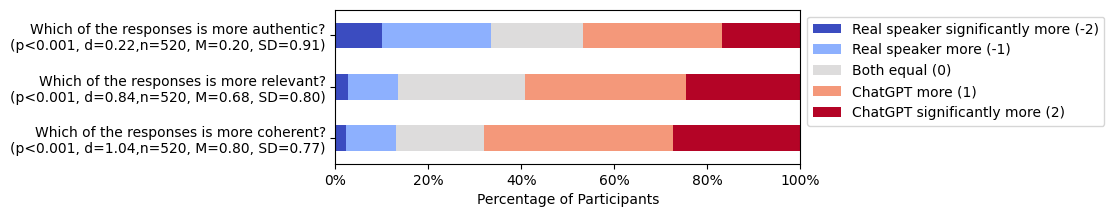

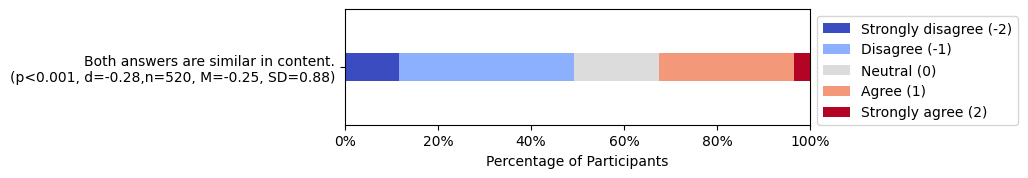

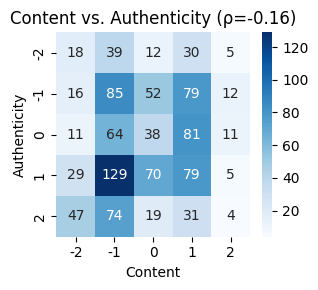

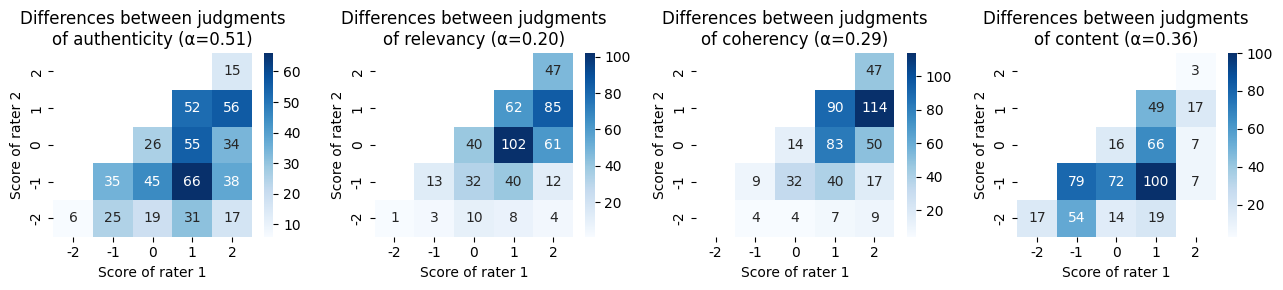

In [39]:
track2_criteria = ['authenticity', 'relevancy', 'coherency', 'content']
track2_criteria_labels = ['Which of the responses is more authentic?', 'Which of the responses is more relevant?', 'Which of the responses is more coherent?', 'Both answers are similar in content.']
track2_meanscores = data_track2_long.groupby(['pair_id']).mean(numeric_only=True).reset_index()

df_track2_counts = pd.DataFrame(index=['Real speaker significantly more (-2)', 'Real speaker more (-1)', 'Both equal (0)', 'ChatGPT more (1)', 'ChatGPT significantly more (2)'], columns=track2_criteria)
labels_with_stats = []
for i, criterion in enumerate(track2_criteria):
    pval = wilcoxon(track2_meanscores[criterion], alternative='two-sided').pvalue
    pivot_df = data_track2_long[['prolific_id', 'pair_id', criterion]].pivot(index='prolific_id', columns=['pair_id'], values=criterion).transpose()
    alpha = pg.cronbach_alpha(pivot_df.transpose())
    effsize = cohen_d_onesample(track2_meanscores[criterion], 0)
    pval_string = pval_to_string(pval)

    value_counts = data_track2_long[criterion].value_counts().sort_index()
    value_counts.index = df_track2_counts.index
    df_track2_counts[criterion] = value_counts

    if pval<sig_level:
        effsize_str = f'd={effsize:.2f}'
    else:
        effsize_str = 'not sig.'

    mean_criterion = track2_meanscores[criterion].mean()
    sd_criterion = track2_meanscores[criterion].std()
    se_criterion = sd_criterion / np.sqrt(len(track2_meanscores))
    label = f'{track2_criteria_labels[i]}\n(p{pval_string}, {effsize_str},n={len(track2_meanscores)}, M={mean_criterion:.2f}, SD={sd_criterion:.2f})'
    labels_with_stats.append(label)
    
df_track2_counts.fillna(0, inplace=True)
df_track2_counts = df_track2_counts/len(data_track2_long)*100

df_track2_counts.columns = labels_with_stats

df_track2_counts.transpose()[::-1][1:].plot(kind='barh', stacked=True, cmap='coolwarm', figsize=(6,2)).legend(bbox_to_anchor=(1, 1))
plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 20))
plt.xticks(np.arange(0, 101, 20), [f'{i}%' for i in range(0, 101, 20)])
plt.xlabel('Percentage of Participants')
plt.ylabel('')
plt.tight_layout()
plt.savefig('figures/track2_results.pdf', bbox_inches='tight')
plt.show()

df_track2_counts.index = ['Strongly disagree (-2)', 'Disagree (-1)', 'Neutral (0)', 'Agree (1)', 'Strongly agree (2)']

plt.figure(figsize=(6,1.5))
ax = plt.gca()
df_track2_counts.transpose()[::-1][:1].plot(kind='barh', stacked=True, cmap='coolwarm', width=0.16, ax=ax).legend(bbox_to_anchor=(1, 1))
ax.set_xlim(0, 100)
ax.set_xticks(np.arange(0, 101, 20))
ax.set_xticks(np.arange(0, 101, 20), [f'{i}%' for i in range(0, 101, 20)])
ax.set_xlabel('Percentage of Participants')
ax.set_ylabel('')
# plt.tight_layout()
plt.savefig('figures/track2_content_results.pdf', bbox_inches='tight')

content_vs_authenticity = data_track2_long[['authenticity', 'content']].groupby(['authenticity', 'content']).size().unstack()
corr = data_track2_long[['authenticity', 'content']].corr(method='spearman').iloc[0,1]

plt.figure(figsize=(3.25,3))
ax = plt.gca()
sns.heatmap(content_vs_authenticity, annot=True, fmt='.0f', cmap='Blues', ax=ax)
ax.set_xlabel('Content')
ax.set_ylabel('Authenticity')
ax.set_title(f'Content vs. Authenticity (ρ={corr:.2f})')
plt.tight_layout()
plt.subplots_adjust(hspace=1)
plt.savefig('figures/track2_content_vs_authenticity.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, len(track2_criteria), figsize=(13, 3))
for i, criterion in enumerate(track2_criteria):
    pivot_df = data_track2_long[['prolific_id', 'pair_id', criterion]].pivot(index='prolific_id', columns=['pair_id'], values=criterion).transpose()
    alpha = pg.cronbach_alpha(pivot_df.transpose())
    
    pair_count_df = pd.DataFrame(index = [-2, -1, 0, 1, 2], columns=[-2, -1, 0, 1, 2])
    pair_count_df.fillna(0, inplace=True)
    for row in data_track2_long[['pair_id', criterion]].groupby(['pair_id']).value_counts().unstack().fillna(0).iterrows():
        pair = []
        for j, col in enumerate(row[1]):
            if col==1:
                pair.append(j-2)
            elif col==2:
                pair.append(j-2)
                pair.append(j-2)
        if len(pair)==2:
            pair_count_df.loc[pair[0], pair[1]] = pair_count_df.loc[pair[0], pair[1]] + 1

    pair_count_df.replace(0, np.nan, inplace=True)
    sns.heatmap(pair_count_df[::-1], annot=True, fmt='.0f', cmap='Blues', ax=ax[i])
    ax[i].set_title(f'Differences between judgments\nof {track2_criteria[i]} (α={alpha[0]:.2f})')
    ax[i].set_xlabel('Score of rater 1')
    ax[i].set_ylabel('Score of rater 2')
plt.tight_layout()
plt.savefig('figures/track2_reliability.pdf')
plt.show()

# Statistics for Track 3

Stats for Track 3
Number of ratings: 3424
Number of data points: 1560

Stats for Track 3
Number of data points with high familarity: 170



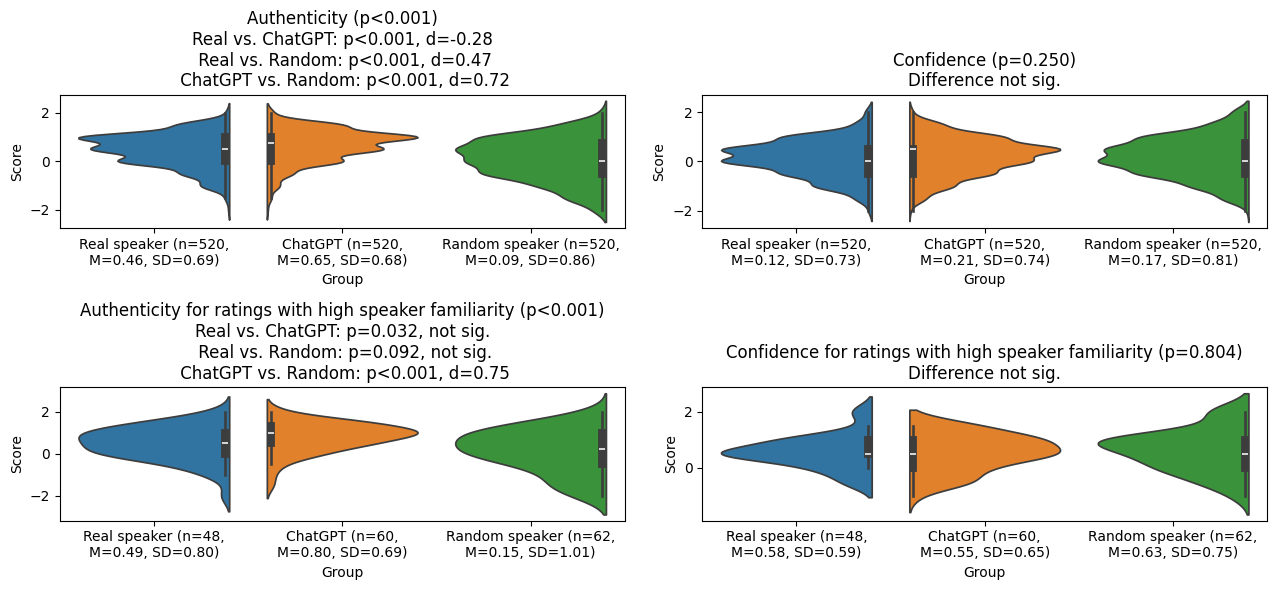

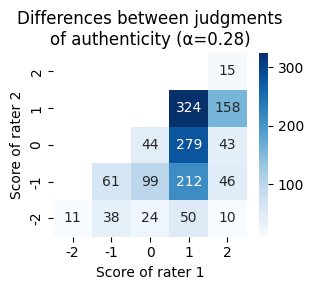

In [45]:
criteria_track3 = ['credibility', 'confidence']
criteria_track3_labels = ['Authenticity', 'Confidence']

track3_meanscores = data_track3_long.groupby(['pair_id', 'is_answer_generated', 'is_speaker_random']).mean(numeric_only=True).reset_index()
mask_real_speaker = (track3_meanscores['is_answer_generated']==False) & (track3_meanscores['is_speaker_random']==False)
mask_random_speaker = (track3_meanscores['is_answer_generated']==False) & (track3_meanscores['is_speaker_random']==True)
mask_generated_answer = track3_meanscores['is_answer_generated']==True

familiarity_threshold = 0
track3_meanscores_high_familiarity = track3_meanscores[track3_meanscores['familarity']>familiarity_threshold]
mask_real_speaker_high_familiarity = (track3_meanscores_high_familiarity['is_answer_generated']==False) & (track3_meanscores_high_familiarity['is_speaker_random']==False)
mask_random_speaker_high_familiarity = (track3_meanscores_high_familiarity['is_answer_generated']==False) & (track3_meanscores_high_familiarity['is_speaker_random']==True)
mask_generated_answer_high_familiarity = track3_meanscores_high_familiarity['is_answer_generated']==True

fig, ax = plt.subplots(2, len(criteria_track3), figsize=(13, 6))
for i, criterion in enumerate(criteria_track3):
    real_scores = track3_meanscores[mask_real_speaker][['pair_id', criterion]]
    gen_scores = track3_meanscores[mask_generated_answer][['pair_id', criterion]]
    rand_scores = track3_meanscores[mask_random_speaker][['pair_id', criterion]]

    merged_scores = real_scores.merge(gen_scores, on='pair_id', suffixes=('_real', '_gen')).merge(rand_scores, on='pair_id')
    merged_scores[criterion+'_rand'] = merged_scores[criterion]
    merged_scores.drop(criterion, axis=1, inplace=True)
    merged_scores = merged_scores.set_index('pair_id')

    pval = friedmanchisquare(merged_scores[criterion+'_real'], merged_scores[criterion+'_gen'], merged_scores[criterion+'_rand']).pvalue
        
    mean_real = merged_scores[criterion+'_real'].mean()
    mean_generated = merged_scores[criterion+'_gen'].mean()
    mean_random = merged_scores[criterion+'_rand'].mean()
    sd_real = merged_scores[criterion+'_real'].std()
    sd_generated = merged_scores[criterion+'_gen'].std()
    sd_random = merged_scores[criterion+'_rand'].std()

    label_real = f'Real speaker (n={len(merged_scores)},\nM={mean_real:.2f}, SD={sd_real:.2f})'
    label_generated = f'ChatGPT (n={len(merged_scores)},\nM={mean_generated:.2f}, SD={sd_generated:.2f})'
    label_random = f'Random speaker (n={len(merged_scores)},\nM={mean_random:.2f}, SD={sd_random:.2f})'
    pval_string = pval_to_string(pval)
    title_string = f'{criteria_track3_labels[i]} (p{pval_string})'

    effsize_real_gen = cohen_d(merged_scores[criterion+'_real'], merged_scores[criterion+'_gen'])
    effsize_real_rand = cohen_d(merged_scores[criterion+'_real'], merged_scores[criterion+'_rand'])
    effsize_gen_rand = cohen_d(merged_scores[criterion+'_gen'], merged_scores[criterion+'_rand'])

    if pval<sig_level:
        # run post-hocs
        pval_real_gen = wilcoxon(real_scores.iloc[:,1], gen_scores.iloc[:,1], alternative='two-sided').pvalue
        pvalstr_real_gen = pval_to_string(pval_real_gen)
        if pval_real_gen<sig_level/3:
            effsize_real_gen = f'p{pvalstr_real_gen}, d={cohen_d(real_scores.iloc[:,1], gen_scores.iloc[:,1]):.2f}'
        else:
            effsize_real_gen = f'p{pvalstr_real_gen}, not sig.'

        pval_real_rand = wilcoxon(real_scores.iloc[:,1], rand_scores.iloc[:,1], alternative='two-sided').pvalue
        pvalstr_real_rand = pval_to_string(pval_real_rand)
        if pval_real_rand/3:
            effsize_real_rand = f'p{pvalstr_real_rand}, d={cohen_d(real_scores.iloc[:,1], rand_scores.iloc[:,1]):.2f}'
        else:
            effsize_real_rand = f'p{pvalstr_real_rand}, not sig.'

        pval_gen_rand = wilcoxon(gen_scores.iloc[:,1], rand_scores.iloc[:,1], alternative='two-sided').pvalue
        pvalstr_gen_rand = pval_to_string(pval_gen_rand)
        if pval_gen_rand<sig_level/3:
            effsize_gen_rand = f'p{pvalstr_gen_rand}, d={cohen_d(gen_scores.iloc[:,1], rand_scores.iloc[:,1]):.2f}'
        else:
            effsize_gen_rand = f'p{pvalstr_gen_rand}, not sig.'
        
        post_hoc_result = f'Real vs. ChatGPT: {effsize_real_gen}\n Real vs. Random: {effsize_real_rand}\n ChatGPT vs. Random: {effsize_gen_rand}'
    else:
        post_hoc_result = 'Difference not sig.'
        
    title_string = title_string + '\n' + post_hoc_result

    merged_scores.columns = [label_real, label_generated, label_random]

    merged_scores_long = merged_scores.reset_index().melt(id_vars='pair_id', var_name='group', value_name='score')
    sns.violinplot(data=merged_scores_long, x='group', y='score', split=True, palette="tab10", ax=ax[0,i])
    ax[0,i].set_title(title_string)
    ax[0,i].set_xlabel('Group')
    ax[0,i].set_ylabel('Score')

for i, criterion in enumerate(criteria_track3):
    pivot_df = data_track3_long[['prolific_id', 'pair_id', 'is_answer_generated', 'is_speaker_random', criterion]].pivot(index='prolific_id', columns=['pair_id', 'is_answer_generated', 'is_speaker_random'], values=criterion)
    alpha = pg.cronbach_alpha(pivot_df.transpose())
    real_scores = track3_meanscores_high_familiarity[mask_real_speaker_high_familiarity][['pair_id', criterion]]
    gen_scores = track3_meanscores_high_familiarity[mask_generated_answer_high_familiarity][['pair_id', criterion]]
    rand_scores = track3_meanscores_high_familiarity[mask_random_speaker_high_familiarity][['pair_id', criterion]]

    real_scores_copy = real_scores.copy(deep=True)
    real_scores_copy['group'] = 'Real'
    gen_scores_copy = gen_scores.copy(deep=True)
    gen_scores_copy['group'] = 'Generated'
    rand_scores_copy = rand_scores.copy(deep=True)
    rand_scores_copy['group'] = 'Random'
    
    pval = kruskal(real_scores.iloc[:,1:], gen_scores.iloc[:,1:], rand_scores.iloc[:,1:]).pvalue[0]

    if pval<sig_level:
        # run post-hocs
        pval_real_gen = mannwhitneyu(real_scores.iloc[:,1], gen_scores.iloc[:,1], alternative='two-sided').pvalue
        pvalstr_real_gen = pval_to_string(pval_real_gen)
        if pval_real_gen<sig_level/3:
            effsize_real_gen = f'p{pvalstr_real_gen}, d={cohen_d(real_scores.iloc[:,1], gen_scores.iloc[:,1]):.2f}'
        else:
            effsize_real_gen = f'p{pvalstr_real_gen}, not sig.'

        pval_real_rand = mannwhitneyu(real_scores.iloc[:,1], rand_scores.iloc[:,1], alternative='two-sided').pvalue
        pvalstr_real_rand = pval_to_string(pval_real_rand)
        if mannwhitneyu(real_scores.iloc[:,1], rand_scores.iloc[:,1], alternative='two-sided').pvalue<sig_level/3:
            effsize_real_rand = f'p{pvalstr_real_rand}, d={cohen_d(real_scores.iloc[:,1], rand_scores.iloc[:,1]):.2f}'
        else:
            effsize_real_rand = f'p{pvalstr_real_rand}, not sig.'

        pval_gen_rand = mannwhitneyu(gen_scores.iloc[:,1], rand_scores.iloc[:,1], alternative='two-sided').pvalue
        pvalstr_gen_rand = pval_to_string(pval_gen_rand)
        if mannwhitneyu(gen_scores.iloc[:,1], rand_scores.iloc[:,1], alternative='two-sided').pvalue<sig_level/3:
            effsize_gen_rand = f'p{pvalstr_gen_rand}, d={cohen_d(gen_scores.iloc[:,1], rand_scores.iloc[:,1]):.2f}'
        else:
            effsize_gen_rand = f'p{pvalstr_gen_rand}, not sig.'
        
        post_hoc_result = f'Real vs. ChatGPT: {effsize_real_gen}\n Real vs. Random: {effsize_real_rand}\n ChatGPT vs. Random: {effsize_gen_rand}'
    else:
        post_hoc_result = 'Difference not sig.'

        
    mean_real = real_scores[criterion].mean()
    mean_generated = gen_scores[criterion].mean()
    mean_random = rand_scores[criterion].mean()
    sd_real = real_scores[criterion].std()
    sd_generated = gen_scores[criterion].std()
    sd_random = rand_scores[criterion].std()

    label_real = f'Real speaker (n={len(real_scores)},\nM={mean_real:.2f}, SD={sd_real:.2f})'
    label_generated = f'ChatGPT (n={len(gen_scores)},\nM={mean_generated:.2f}, SD={sd_generated:.2f})'
    label_random = f'Random speaker (n={len(rand_scores)},\nM={mean_random:.2f}, SD={sd_random:.2f})'
    pval_string = pval_to_string(pval)
    title_string = f'{criteria_track3_labels[i]} for ratings with high speaker familiarity (p{pval_string})'
    title_string = title_string + '\n' + post_hoc_result

    merged_scores_long = pd.concat([real_scores_copy, gen_scores_copy, rand_scores_copy], axis=0)
    sns.violinplot(data=merged_scores_long, x='group', y=criterion, split=True, palette="tab10", ax=ax[1,i])
    ax[1,i].set_xticklabels([label_real, label_generated, label_random])
    ax[1,i].set_title(title_string)
    ax[1,i].set_xlabel('Group')
    ax[1,i].set_ylabel('Score')
plt.tight_layout()
plt.savefig('figures/track3_violin.pdf')
plt.show()

# reliability track 3
fig, ax = plt.subplots(1, 1, figsize=(3.25, 3))
criterion = 'credibility'
pivot_df = data_track3_long[['prolific_id', 'pair_id', 'is_answer_generated', 'is_speaker_random', criterion]].pivot(index='prolific_id', columns=['pair_id', 'is_answer_generated', 'is_speaker_random'], values=criterion)
alpha = pg.cronbach_alpha(pivot_df.transpose())
pair_count_df = pd.DataFrame(index = [-2, -1, 0, 1, 2], columns=[-2, -1, 0, 1, 2])
pair_count_df.fillna(0, inplace=True)
for row in data_track3_long[['pair_id', 'is_answer_generated', 'is_speaker_random', criterion]].groupby(['pair_id', 'is_answer_generated', 'is_speaker_random']).value_counts().unstack().fillna(0).iterrows():
    pair = []
    for j, col in enumerate(row[1]):
        if col==1:
            pair.append(j-2)
        elif col==2:
            pair.append(j-2)
            pair.append(j-2)
    if len(pair)==2:
        pair_count_df.loc[pair[0], pair[1]] = pair_count_df.loc[pair[0], pair[1]] + 1

pair_count_df.replace(0, np.nan, inplace=True)
sns.heatmap(pair_count_df[::-1], annot=True, fmt='.0f', cmap='Blues', ax=ax)
ax.set_title(f'Differences between judgments\nof authenticity (α={alpha[0]:.2f})')
ax.set_xlabel('Score of rater 1')
ax.set_ylabel('Score of rater 2')
plt.tight_layout()
plt.savefig('figures/track3_reliability.pdf')
plt.show()

# Statistics for linguistic markers

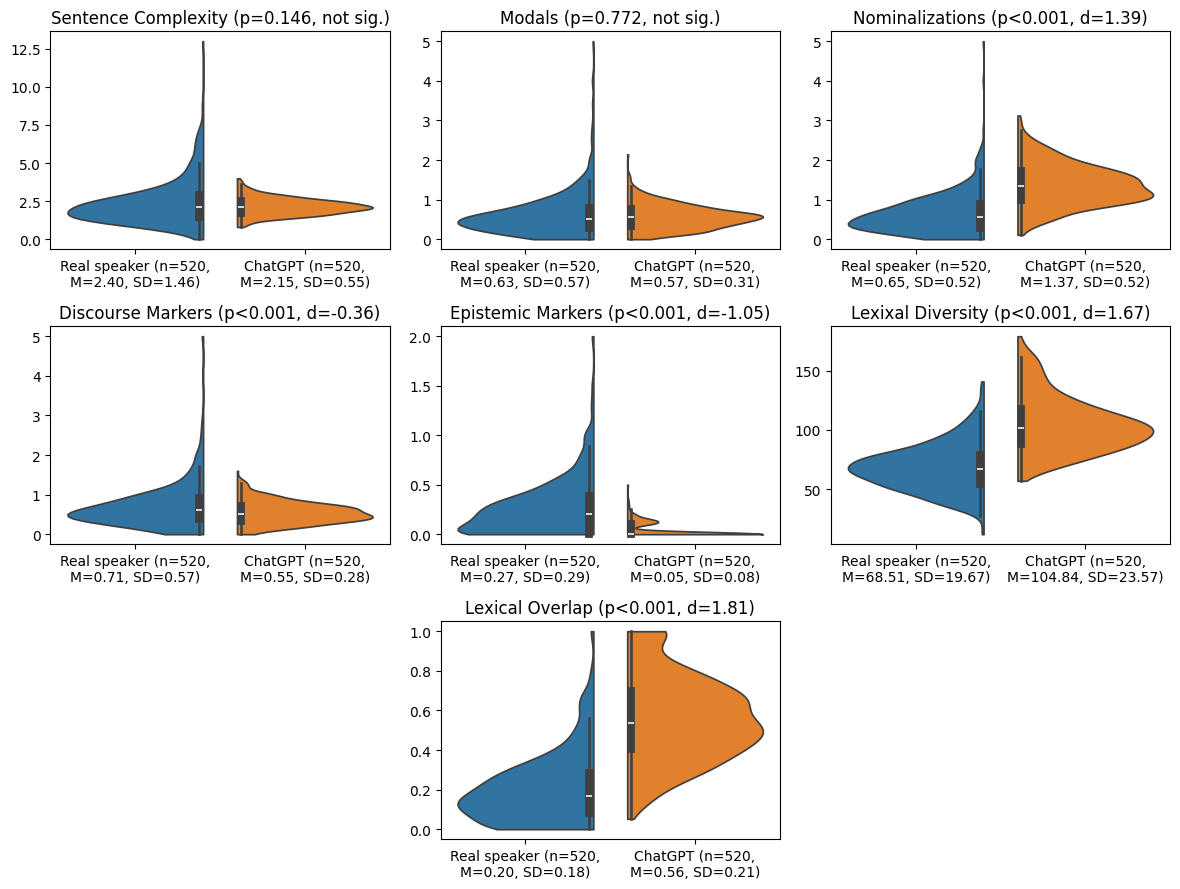

In [40]:
linguistic_data = pd.read_csv(linguistic_data_path)

linguistic_criteria = ['sent_complex_tags', 'mod_per_sent', 'nom_per_sent', 'dm_per_sent', 'ep_per_sent', 'LD', 'overlap_per_word']
lingustic_criteria_strings = ['Sentence Complexity', 'Modals', 'Nominalizations', 'Discourse Markers', 'Epistemic Markers', 'Lexixal Diversity', 'Lexical Overlap']

plt.figure(figsize=(12,9))
ax = []
ax.append(plt.subplot2grid(shape=(3,3), loc=(0,0), colspan=1))
ax.append(plt.subplot2grid(shape=(3,3), loc=(0,1), colspan=1))
ax.append(plt.subplot2grid(shape=(3,3), loc=(0,2), colspan=1))
ax.append(plt.subplot2grid(shape=(3,3), loc=(1,0), colspan=1))
ax.append(plt.subplot2grid(shape=(3,3), loc=(1,1), colspan=1))
ax.append(plt.subplot2grid(shape=(3,3), loc=(1,2), colspan=1))
ax.append(plt.subplot2grid(shape=(3,3), loc=(2,1), colspan=1))

for i, criterion in enumerate(linguistic_criteria):
    population_real = linguistic_data['REAL_'+criterion]
    population_gen = linguistic_data['GPT_'+criterion]
    res = wilcoxon(population_real, population_gen, alternative='two-sided')
    effsize = cohen_d(population_gen, population_real)
    pval_string = pval_to_string(res.pvalue)

    mean_real = population_real.mean()
    mean_generated = population_gen.mean()
    sd_real = population_real.std()
    sd_generated = population_gen.std()

    label_real = f'Real speaker (n={len(population_real)},\nM={mean_real:.2f}, SD={sd_real:.2f})'
    label_generated = f'ChatGPT (n={len(population_real)},\nM={mean_generated:.2f}, SD={sd_generated:.2f})'

    if res.pvalue<sig_level:
        title_string = f'{lingustic_criteria_strings[i]} (p{pval_string}, d={effsize:.2f})'
    else:
        title_string = f'{lingustic_criteria_strings[i]} (p{pval_string}, not sig.)'

    paired_means = pd.concat([population_real.reset_index(drop=True), population_gen.reset_index(drop=True)], axis=1)
    paired_means.columns = [label_real, label_generated]
    sns.violinplot(data=linguistic_data[[f'REAL_{criterion}', f'GPT_{criterion}']], ax=ax[i], split=True, cut=0)
    ax[i].set_title(title_string)
    ax[i].set_xticklabels([label_real, label_generated])
plt.tight_layout()
plt.savefig('figures/linguistic_violin.pdf', bbox_inches='tight')
plt.show()

# Analysis of Exit Poll

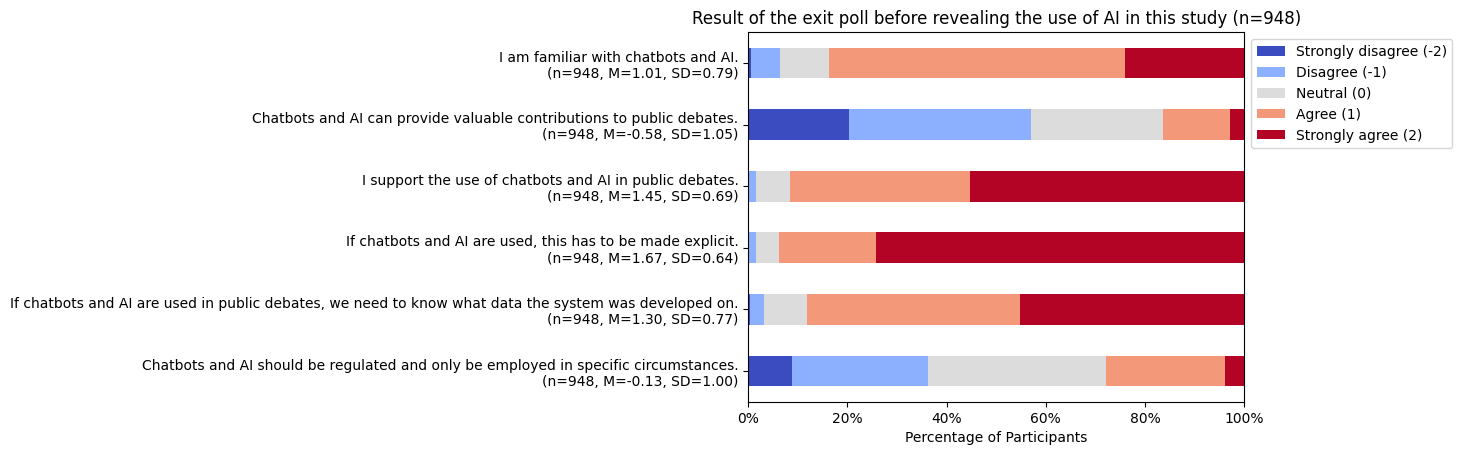

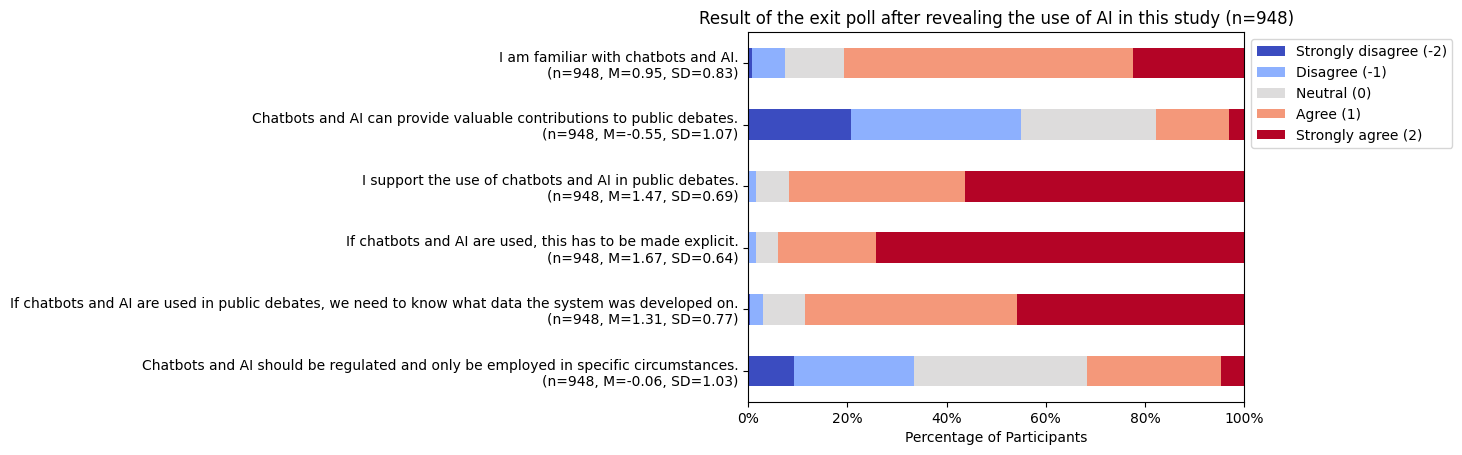

In [41]:
exit_poll_criteria = ['exit1_chatbot_knowledge', 'exit1_chatbot_participant_debate', 'exit1_chatbot_participant_debate_details', 'exit1_chatbot_participant_debate_label', 'exit1_chatbot_participant_debate_regulated', 'exit1_chatbot_usefull_debate']

exit_poll_questions = ['I am familiar with chatbots and AI.',
                       'Chatbots and AI can provide valuable contributions to public debates.',
                       'I support the use of chatbots and AI in public debates.',
                       'If chatbots and AI are used, this has to be made explicit.',
                       'If chatbots and AI are used in public debates, we need to know what data the system was developed on.',
                       'Chatbots and AI should be regulated and only be employed in specific circumstances.']

df_exit_poll_counts = pd.DataFrame(index=['Strongly disagree', 'Disagree', 'Neutral', 'Agree', 'Strongly agree'], columns=exit_poll_criteria)

exit_poll_labels = []
for criterion in exit_poll_criteria:
    df_exit_poll_counts[criterion] = exit_poll[criterion].value_counts()
    cur_mean = exit_poll[criterion].map(likert_scale_map_agreement).mean()
    cur_sd = exit_poll[criterion].map(likert_scale_map_agreement).std()
    exit_poll_labels.append(f'{exit_poll_questions[len(exit_poll_labels)]}\n(n={len(exit_poll)}, M={cur_mean:.2f}, SD={cur_sd:.2f})')
df_exit_poll_counts.fillna(0, inplace=True)
df_exit_poll_counts = df_exit_poll_counts/len(exit_poll)*100

df_exit_poll_counts.columns = exit_poll_labels
df_exit_poll_counts.index = ['Strongly disagree (-2)', 'Disagree (-1)', 'Neutral (0)', 'Agree (1)', 'Strongly agree (2)']

df_exit_poll_counts.transpose()[::-1].plot(kind='barh', stacked=True, cmap='coolwarm').legend(bbox_to_anchor=(1, 1))
plt.title(f'Result of the exit poll before revealing the use of AI in this study (n={len(exit_poll)})')
plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 20))
plt.xticks(np.arange(0, 101, 20), [f'{i}%' for i in range(0, 101, 20)])
plt.xlabel('Percentage of Participants')
plt.ylabel('')
plt.savefig('figures/exit_poll_before.pdf', bbox_inches='tight')
plt.show()

exit_poll_criteria = ['exit2_chatbot_knowledge', 'exit2_chatbot_participant_debate', 'exit2_chatbot_participant_debate_details', 'exit2_chatbot_participant_debate_label', 'exit2_chatbot_participant_debate_regulated', 'exit2_chatbot_usefull_debate']

exit_poll_questions = ['I am familiar with chatbots and AI.',
                       'Chatbots and AI can provide valuable contributions to public debates.',
                       'I support the use of chatbots and AI in public debates.',
                       'If chatbots and AI are used, this has to be made explicit.',
                       'If chatbots and AI are used in public debates, we need to know what data the system was developed on.',
                       'Chatbots and AI should be regulated and only be employed in specific circumstances.']

df_exit_poll_counts = pd.DataFrame(index=['Strongly disagree', 'Disagree', 'Neutral', 'Agree', 'Strongly agree'], columns=exit_poll_criteria)

exit_poll_labels = []
for criterion in exit_poll_criteria:
    df_exit_poll_counts[criterion] = exit_poll[criterion].value_counts()
    cur_mean = exit_poll[criterion].map(likert_scale_map_agreement).mean()
    cur_sd = exit_poll[criterion].map(likert_scale_map_agreement).std()
    exit_poll_labels.append(f'{exit_poll_questions[len(exit_poll_labels)]}\n(n={len(exit_poll)}, M={cur_mean:.2f}, SD={cur_sd:.2f})')
df_exit_poll_counts.fillna(0, inplace=True)
df_exit_poll_counts = df_exit_poll_counts/len(exit_poll)*100

df_exit_poll_counts.columns = exit_poll_labels
df_exit_poll_counts.index = ['Strongly disagree (-2)', 'Disagree (-1)', 'Neutral (0)', 'Agree (1)', 'Strongly agree (2)']

df_exit_poll_counts.transpose()[::-1].plot(kind='barh', stacked=True, cmap='coolwarm').legend(bbox_to_anchor=(1, 1))
plt.title(f'Result of the exit poll after revealing the use of AI in this study (n={len(exit_poll)})')
plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 20))
plt.xticks(np.arange(0, 101, 20), [f'{i}%' for i in range(0, 101, 20)])
plt.xlabel('Percentage of Participants')
plt.ylabel('')
plt.savefig('figures/exit_poll_after.pdf', bbox_inches='tight')
plt.show()

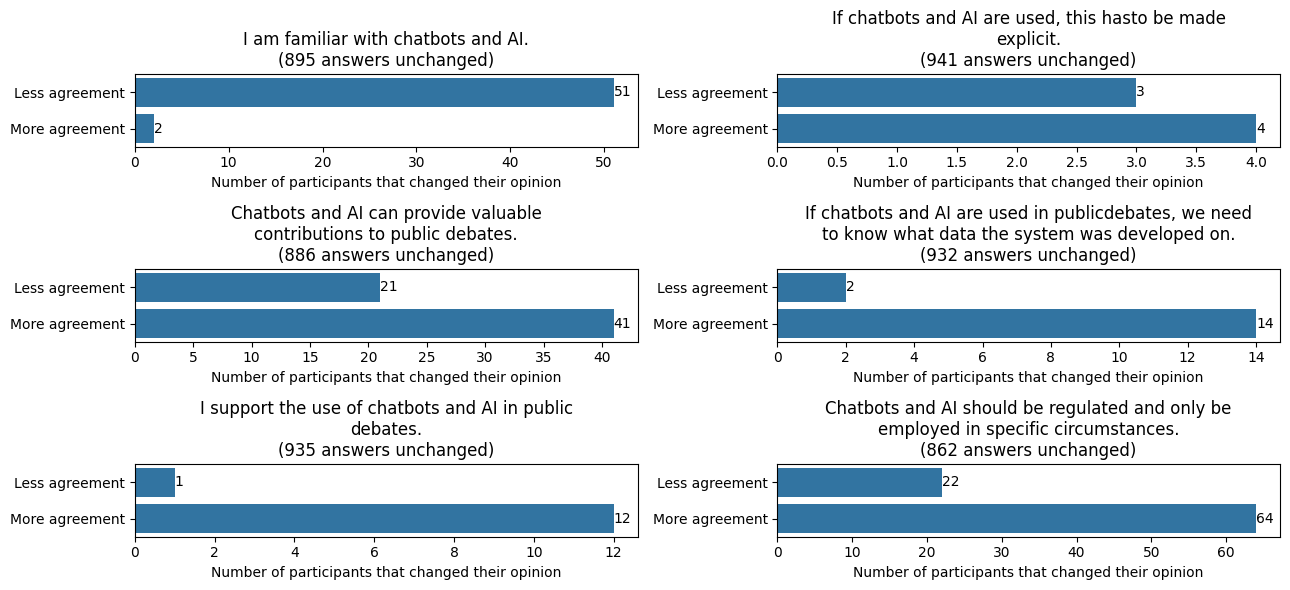

In [42]:
exit_poll_criteria = ['chatbot_knowledge', 'chatbot_participant_debate', 'chatbot_participant_debate_details', 'chatbot_participant_debate_label', 'chatbot_participant_debate_regulated', 'chatbot_usefull_debate']

exit_poll_criteria_labels = ['I am familiar with chatbots and AI.',
                            'Chatbots and AI can provide valuable\ncontributions to public debates.',
                            'I support the use of chatbots and AI in public\ndebates.',
                            'If chatbots and AI are used, this hasto be made\nexplicit.',
                            'If chatbots and AI are used in publicdebates, we need\nto know what data the system was developed on.',
                            'Chatbots and AI should be regulated and only be\nemployed in specific circumstances.']

exit_poll_differences = pd.DataFrame(columns=exit_poll_criteria)
exit_poll_polar = pd.DataFrame(columns=exit_poll_criteria)

fig, ax = plt.subplots(3, 2, figsize=(13, 6))
for i, criterion in enumerate(exit_poll_criteria):
    exit_poll_differences[criterion] = exit_poll[f'exit2_{criterion}'].map(likert_scale_map_agreement) - exit_poll[f'exit1_{criterion}'].map(likert_scale_map_agreement)
    exit_poll_differences[criterion] = exit_poll_differences[criterion].apply(lambda x: 'Positive' if x>0 else 'Negative' if x<0 else 'No change')
    # plot changes as bar chart
    cur_ax = ax[i%3, int(i/3)]
    #exit_poll_differences[criterion].value_counts().sort_index().drop('No change').plot(kind='barh', ax=cur_ax)
    cur_counts = exit_poll_differences[criterion].value_counts().sort_index()
    sns.barplot(cur_counts.drop('No change'), orient='h', ax=cur_ax)
    cur_ax.bar_label(cur_ax.containers[0], fontsize=10);
    cur_ax.set_title(exit_poll_criteria_labels[i]+f'\n({cur_counts["No change"]} answers unchanged)')
    cur_ax.set_yticklabels(['Less agreement', 'More agreement'])
    cur_ax.set_xlabel('Number of participants that changed their opinion')
    cur_ax.set_ylabel('')
plt.tight_layout()
plt.savefig('figures/exit_poll_changes.pdf', bbox_inches='tight')
plt.show()

In [43]:
# Optional: uncomment to export free text answers for annotation
# exit_poll[['prolific_id', 'exit2_reason_changes']].dropna().to_csv('data/exit_poll_reasons_nocodes.csv', index=False)

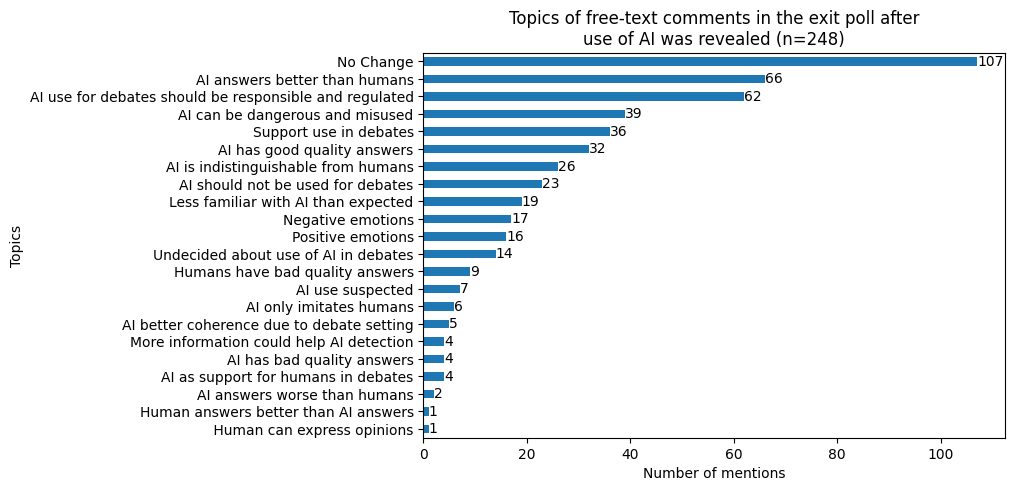

In [44]:
exit_poll_free_text = pd.read_csv(free_text_annotations_path)
code_categories = pd.read_csv(free_text_codebook_path)

# extract all codes
codes = []
for i, row in exit_poll_free_text.iterrows():
    if pd.notna(row['codes']):
        codes.extend([code.strip() for code in row['codes'].split(';')])
codes = list(set(codes))

# create a dataframe with all codes
exit_poll_codes = pd.DataFrame(index=codes)
exit_poll_codes['count'] = 0

# count the occurences of each code
for i, row in exit_poll_free_text.iterrows():
    if pd.notna(row['codes']):
        for code in [code.strip() for code in row['codes'].split(';')]:
            exit_poll_codes.loc[code, 'count'] += 1

# merge with code categories
exit_poll_codes = exit_poll_codes.merge(code_categories, left_index=True, right_on='code', how='left')

category_counts = exit_poll_codes[['category', 'count']].groupby('category').sum().drop('Other').sort_values('count', ascending=False)
ax = category_counts[::-1].plot(kind='barh', figsize=(7.5,5), legend=False)
ax = plt.gca()
ax.bar_label(ax.containers[0], fontsize=10);
plt.xlabel('Number of mentions')
plt.ylabel('Topics')
plt.title(f'Topics of free-text comments in the exit poll after\nuse of AI was revealed (n={len(exit_poll_free_text)})')
#plt.tight_layout()
plt.savefig('figures/exit_poll_categories.pdf', bbox_inches='tight')
plt.show()